In [2]:
from backend.model.llm_handler import LLMHandler
import torch

/Users/mat/anaconda3/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_handler = LLMHandler()

`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attenton` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.
Loading checkpoint shards: 100%|██████████| 2/2 [00:11<00:00,  5.93s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
model = model_handler.model
model

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3SuScaledRotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features=3072, out_featu

In [5]:
model.vocab_size

32064

In [6]:
model.config

Phi3Config {
  "_name_or_path": "microsoft/phi-3-mini-128k-instruct",
  "architectures": [
    "Phi3ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoConfig": "microsoft/phi-3-mini-128k-instruct--configuration_phi3.Phi3Config",
    "AutoModelForCausalLM": "microsoft/phi-3-mini-128k-instruct--modeling_phi3.Phi3ForCausalLM"
  },
  "bos_token_id": 1,
  "embd_pdrop": 0.0,
  "eos_token_id": 32000,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "model_type": "phi3",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "original_max_position_embeddings": 4096,
  "pad_token_id": 32000,
  "resid_pdrop": 0.0,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "long_factor": [
      1.0299999713897705,
      1.0499999523162842,
      1.0499999523162842,
      1.0799999237060547,
      1.2299998998641968,
      1.2299998998641968,
      1.29999995231

In [7]:
tokenizer = model_handler.tokenizer
tokenizer

LlamaTokenizerFast(name_or_path='microsoft/phi-3-mini-128k-instruct', vocab_size=32000, model_max_length=131072, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '<|endoftext|>', 'unk_token': '<unk>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=True, lstrip=False, single_word=False, normalized=False, special=False),
	32000: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32001: AddedToken("<|assistant|>", rstrip=True, lstrip=False, single_word=False, normalized=False, special=True),
	32002: AddedToken("<|placeholder1|>", rstrip=True, lstrip=False, single_word=False, normalized=False, spec

In [8]:
tokenizer.vocab_size

32000

For the phi3-128k model there is an apparent mismatch between the vocab sizes of model and tokenizer (model 32064, tokenizer 32000). However, inspecting the config files here (https://huggingface.co/microsoft/Phi-3-mini-128k-instruct) it seems that special tokens have been added in the same positions at the end. Counting them, it would seem that both have at least 32010 tokens). So either some extra tokens have been added to the model (unlikely) or there was some bookkeeping mistake.

In [34]:
test_strings = [
    "I am a test string",
    "Here is another test string",
    "One more test string",
]
for s in test_strings:
    print("Original string:", s)
    print("Encoded string:", tokenizer.encode(s))
    print("Decoded string:", tokenizer.decode(tokenizer.encode(s)))
    print("_________________________")

Original string: I am a test string
Encoded string: [1, 306, 626, 263, 1243, 1347]
Decoded string: <s> I am a test string
_________________________
Original string: Here is another test string
Encoded string: [1, 2266, 338, 1790, 1243, 1347]
Decoded string: <s> Here is another test string
_________________________
Original string: One more test string
Encoded string: [1, 3118, 901, 1243, 1347]
Decoded string: <s> One more test string
_________________________


CAREFUL! Encoding with the tokenizer adds a start token by default. Therefore, encoding followed by decoding does not take you back to the original string, it adds start token to the original string, even in case it already had one.

In [41]:
# from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("gpt2")
# tokenizer.decode(tokenizer.encode("I am a test string"))

In [44]:
isinstance(model, torch.nn.Module)

True

In [52]:
input_sentences = ["I am a test string", "Here is another test string", "One more test string. This one is longer."]
input_ids = tokenizer(input_sentences, return_tensors="pt", padding=True, truncation=True)
print(input_ids['input_ids'])
print(input_ids['attention_mask'])

tensor([[32000, 32000, 32000, 32000, 32000,     1,   306,   626,   263,  1243,
          1347],
        [32000, 32000, 32000, 32000, 32000,     1,  2266,   338,  1790,  1243,
          1347],
        [    1,  3118,   901,  1243,  1347, 29889,   910,   697,   338,  5520,
         29889]])
tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


padding adds token id 32000 on the left! Start token has id 1.

In [53]:
model_output = model(**input_ids)
model_output

You are not running the flash-attention implementation, expect numerical differences.


CausalLMOutputWithPast(loss=None, logits=tensor([[[ 4.7051,  6.0801,  6.5220,  ...,  0.0000,  0.0000,  0.0000],
         [ 4.7051,  6.0801,  6.5220,  ...,  0.0000,  0.0000,  0.0000],
         [ 4.7051,  6.0801,  6.5220,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [10.0889,  7.7215, 11.5303,  ...,  0.0000,  0.0000,  0.0000],
         [ 9.1359,  5.6657, 12.3421,  ...,  0.0000,  0.0000,  0.0000],
         [ 7.5674,  8.8302, 13.6358,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 6.2828,  8.2451,  7.1792,  ...,  0.0000,  0.0000,  0.0000],
         [ 6.2828,  8.2451,  7.1792,  ...,  0.0000,  0.0000,  0.0000],
         [ 6.2828,  8.2451,  7.1792,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 9.4208,  9.0746, 10.4158,  ...,  0.0000,  0.0000,  0.0000],
         [ 9.2520,  9.8985, 11.6319,  ...,  0.0000,  0.0000,  0.0000],
         [ 8.8653, 10.5135, 14.1192,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 2.6440,  2.8383,  0.4343,  ...,  0.0000,  0.0000,  0.0000],
    

In [54]:
model_output.keys()

odict_keys(['logits', 'past_key_values'])

In [60]:
model_output.logits.shape  # (batch_size, sequence_length, vocab_size)

torch.Size([3, 11, 32064])

In [68]:
# get next token predictions for each token in the input doing argmax
predicted_token_ids = torch.argmax(model_output.logits, dim=-1)
# mask out padding tokens
predicted_token_ids = predicted_token_ids * input_ids['attention_mask']
predicted_token_ids

tensor([[    0,     0,     0,     0,     0, 26785, 29915,  1811, 29871,   261,
         29889],
        [    0,     0,     0,     0,     0, 26785,   338,   263,  1342,  1206,
         29901],
        [26785,     2,  1139,  1206, 29901,   910,   338,   338,  5520,  1135,
           739]])

In [77]:
tokenizer.decode(predicted_token_ids[2])

'RESS</s> question case: This is is longer than It'

In [59]:
model_output.past_key_values

((tensor([[[[ 2.5185e-01,  2.9447e-01, -3.4902e-01,  ...,  1.1767e+00,
             -1.4033e+00, -1.2342e+00],
            [-1.8224e-01, -1.6650e-01, -3.3405e-02,  ...,  1.1767e+00,
             -1.4033e+00, -1.2342e+00],
            [-4.6316e-01, -5.2977e-01,  2.9579e-01,  ...,  1.1766e+00,
             -1.4032e+00, -1.2341e+00],
            ...,
            [ 9.2223e-02,  1.7035e-03,  3.8568e-01,  ..., -4.4334e-02,
             -2.9444e-01, -3.3451e-02],
            [ 3.4154e-01,  1.9089e-01,  7.7414e-02,  ..., -9.0030e-02,
             -6.2477e-02,  5.3321e-02],
            [ 1.2418e-01,  1.1407e-01, -5.4527e-02,  ..., -9.6166e-02,
              2.9009e-01,  1.6840e-01]],
  
           [[ 1.1135e+00, -7.4802e-01, -7.3094e-01,  ..., -3.5324e-01,
              1.3634e-01,  3.1626e-01],
            [ 6.0553e-01, -4.6969e-01, -6.0606e-01,  ..., -3.5323e-01,
              1.3635e-01,  3.1624e-01],
            [-4.1136e-01,  8.4245e-02, -2.3484e-01,  ..., -3.5323e-01,
              1.3636

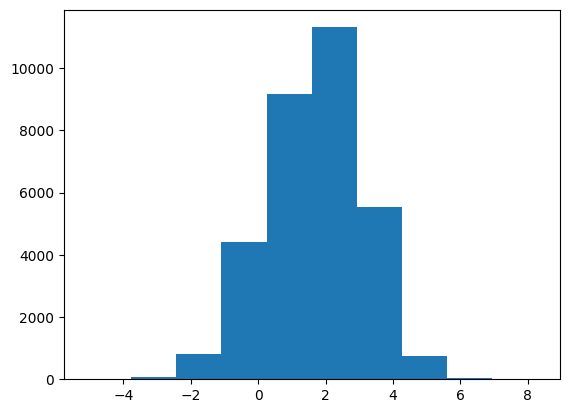

In [82]:
from matplotlib import pyplot as plt

plt.hist(model_output.logits[2][0].detach().numpy())
plt.show()

In [83]:
model_output.logits[2][0][26785]

tensor(8.2779, grad_fn=<SelectBackward0>)

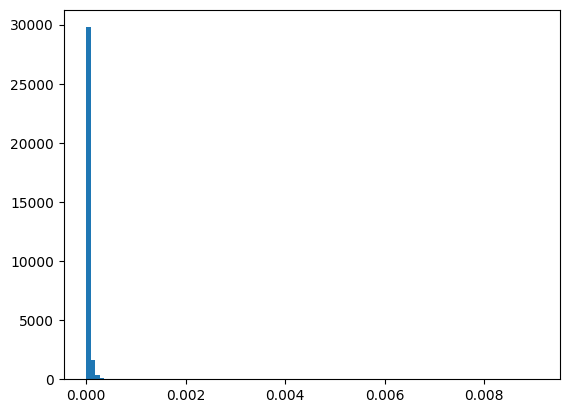

In [94]:
probas = torch.nn.functional.softmax(model_output.logits, dim=-1)

plt.hist(probas[2][0].detach().numpy(), bins=100)
# plt.xlim(0, 0.0005)
plt.show()

In [91]:
probas[2][0][26785]

tensor(0.0091, grad_fn=<SelectBackward0>)

In [102]:
import numpy as np
np.quantile(probas[2][0].detach().numpy(), 0.999)

0.0007287683413014787

In [114]:
K = 30
most_likely = torch.topk(probas[2][0], K)
for i in range(K):
    print(tokenizer.decode(most_likely.indices[i].unsqueeze(0)))

RESS
ktion
}`


オ
ício
ución
march
ju
opp
iry
elect
orig
Η
y
oss
intro
C
b
C
 
Τ
选
(


and
bar
L
integral


In [9]:
# prompt = "RESS"
# input_ids = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
input_ids = {"input_ids": torch.tensor([[1, 26785]]), "attention_mask": torch.tensor([[1, 1]])}
model_output = model(**input_ids)

You are not running the flash-attention implementation, expect numerical differences.


In [133]:
input_ids

{'input_ids': tensor([[    1, 26785]]), 'attention_mask': tensor([[1, 1]])}

In [134]:
model_output.logits.shape

torch.Size([1, 2, 32064])

In [141]:
most_likely = torch.topk(model_output.logits[0][1], 30)
for i in range(30):
    print(tokenizer.decode(most_likely.indices[i].unsqueeze(0)))

SE
ENT
EN
ING
ON
ER
ION
<|end|>
ANT
SS
A
AGE
I
S
IST
ID
SEE
_
>
]
ST
O
-
C
IS
}}
H
IT
OR
ULT


In [122]:
most_likely.indices

tensor([[26785,  7066, 24278, 30751, 29871, 30514, 24394, 16249,  8575,  3623],
        [29943,  7390, 29924,  6720,  5438, 14130,  3035, 29901, 16365, 32007],
        [ 1164, 29909,  1430,  3919,  1001,  8647, 29949, 20161, 29965,  4574]])

In [10]:
model_output.logits.shape

torch.Size([1, 2, 32064])

In [16]:
len(model_output.past_key_values)  # one per layer (phi3 has 32)

32

In [18]:
len(model_output.past_key_values[0])

2

In [22]:
model_output.past_key_values[0][0].shape  # (batch_size, num_heads (phi3 has 32), sequence_length - 1, embed_size_per_head (phi3 has 96))

torch.Size([1, 32, 2, 96])

In [23]:
model_output.past_key_values[0][1].shape

torch.Size([1, 32, 2, 96])

docs for a different model here. https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5Model.forward.past_key_values